# Lab 5: Spatial Autocorrelation

In this lab, you will investigate how the crimes in the city of Chicago are spatially autocorrelated with Global and Local Moran's I. 

The data of this lab was obtained from the following resources. <br>
* Police stations: https://data.cityofchicago.org/Public-Safety/Police-Stations/z8bn-74gv <br>
* Crime data: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2 <br>
* Community area boundaries: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6 <br>

## Notes:
**Before you submit your lab, make sure everything runs as expected WITHOUT ANY ERROR.** <br>
**Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`:**

In [1]:
FULL_NAME = ""

In [1]:
# Import necessary packages
import pandas as pd
import geopandas as gpd
import esda
import libpysal
import math
import matplotlib.pyplot as plt
import ast
from shapely.geometry import Point

## 1. Import Data

In this lab, you will be using the following two datasets. `homicide` variable has the number of homicide happened in each community area in the city of Chicago in 2021. `p_stations` is the locations of police stations in the city of Chicago. 

**1.1.** (0.2 point) Load `homicide_chicago.json` in the data folder as the name of `homicide` with GeoPandas.<br>
**1.2.** (0.2 point) Load `police_stations.csv` in the data folder as the name of `p_stations` with Pandas

In [2]:
# Your code here
homicide = gpd.read_file('./data/homicide_chicago.json')
p_stations = pd.read_csv('./data/police_stations.csv')

In [3]:
homicide.head()

,community,homicide_count,geometry
0,ROGERS PARK,2.0,"MULTIPOLYGON (((356237.252 592121.963, 356139...."
1,WEST RIDGE,2.0,"MULTIPOLYGON (((353725.693 594470.512, 353726...."
2,UPTOWN,2.0,"MULTIPOLYGON (((357397.317 587314.536, 357151...."
3,LINCOLN SQUARE,2.0,"MULTIPOLYGON (((354611.374 589658.580, 354611...."
4,NORTH CENTER,2.0,"MULTIPOLYGON (((354735.306 584798.734, 354730...."


In [4]:
p_stations.head()

,DISTRICT,ADDRESS,CITY,STATE,ZIP,WEBSITE,LOCATION
0,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,"(41.8307016873, -87.6233953459)"
1,18,1160 N Larrabee St,Chicago,IL,60610,http://home.chicagopolice.org/community/distri...,"(41.9032416531, -87.6433521393)"
2,19,850 W Addison St,Chicago,IL,60613,http://home.chicagopolice.org/community/distri...,"(41.9474004564, -87.651512018)"
3,20,5400 N Lincoln Ave,Chicago,IL,60625,http://home.chicagopolice.org/community/distri...,"(41.9795495131, -87.6928445094)"
4,22,1900 W Monterey Ave,Chicago,IL,60643,http://home.chicagopolice.org/community/distri...,"(41.6914347795, -87.6685203937)"


In [5]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(homicide) == gpd.GeoDataFrame
assert type(p_stations) == pd.DataFrame

print('Success!')

Success!


Now, you need to convert `p_stations` from Pandas DataFrame to GeoPandas GeoDataFrame. Here, you need to obtain coordinates from `LOCATION` column and the format is `'(41.8307016873, -87.6233953459)'`, which is a string. `ast.literal_eval` will help you to convert the string to a tuple. <br><br>
Copy and paste the following two lines. It will help you to obtain coordinates from `LOCATION` column and create `lat` and `lng` columns. 

```python
p_stations['lat'] = p_stations.apply(lambda x: ast.literal_eval(x['LOCATION'])[0], axis=1)
p_stations['lng'] = p_stations.apply(lambda x: ast.literal_eval(x['LOCATION'])[1], axis=1)
```

Visit <a href=https://docs.python.org/3/library/ast.html#ast.literal_eval> here </a> for more information.

In [6]:
# Your code here
p_stations['lat'] = p_stations.apply(lambda x: ast.literal_eval(x['LOCATION'])[0], axis=1)
p_stations['lng'] = p_stations.apply(lambda x: ast.literal_eval(x['LOCATION'])[1], axis=1)

**1.3.** (0.3 point) Convert `p_stations` from Pandas DataFrame to GeoPandas GeoDataFrame. Then, assign the coordinates system with the current coordinates as WGS84 (epsg=4326), and change the coordinate coordinate system to the Illinois East State Plane with meters (epsg=26971). 

In [7]:
# Your code here
p_stations = gpd.GeoDataFrame(p_stations, geometry=gpd.points_from_xy(p_stations['lng'], p_stations['lat']))
p_stations = p_stations.set_crs(epsg=4326)
p_stations = p_stations.to_crs(epsg=26971)
p_stations.head()

,DISTRICT,ADDRESS,CITY,STATE,ZIP,WEBSITE,LOCATION,lat,lng,geometry
0,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,"(41.8307016873, -87.6233953459)",41.830702,-87.623395,POINT (358973.018 573542.666)
1,18,1160 N Larrabee St,Chicago,IL,60610,http://home.chicagopolice.org/community/distri...,"(41.9032416531, -87.6433521393)",41.903242,-87.643352,POINT (357250.435 581586.083)
2,19,850 W Addison St,Chicago,IL,60613,http://home.chicagopolice.org/community/distri...,"(41.9474004564, -87.651512018)",41.947400,-87.651512,POINT (356534.347 586485.382)
3,20,5400 N Lincoln Ave,Chicago,IL,60625,http://home.chicagopolice.org/community/distri...,"(41.9795495131, -87.6928445094)",41.979550,-87.692845,POINT (353080.452 590029.749)
4,22,1900 W Monterey Ave,Chicago,IL,60643,http://home.chicagopolice.org/community/distri...,"(41.6914347795, -87.6685203937)",41.691435,-87.668520,POINT (355344.145 558044.728)


In [8]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(p_stations) == gpd.GeoDataFrame
assert p_stations.crs.name == 'NAD83 / Illinois East'
assert p_stations.loc[p_stations['ADDRESS'] == '3510 S Michigan Ave', 'geometry'][0] == Point(358973.01836538664, 573542.6662097769)

print('Success!')

Success!


**1.4.** (0.3 point) Plot two layers (`homicide` and `p_stations`) to ***one*** map based on the description below. Set the figsize to (7, 10).
* Choropleth map of `homicide`: 
    * column: `homicide_count`
    * color map: Reds
    * classification method: Fisher Jenks
    * Show legend

* Location of `p_stations`:
    * markersize: 100
    * color: black
    
The result should look like the below. 
![](./data/fig1.jpg)

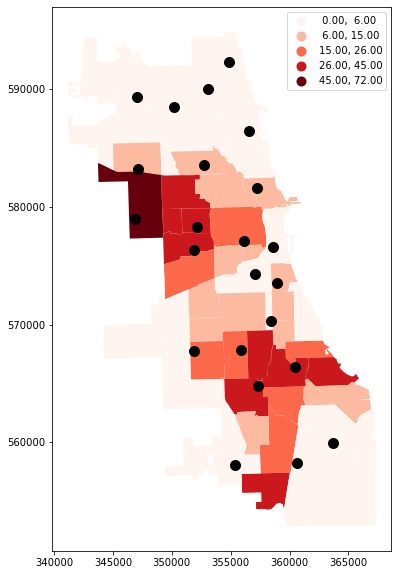

In [9]:
# Your code here
fig, ax = plt.subplots(figsize=(7, 10))

homicide.plot(column='homicide_count', ax=ax, cmap='Reds', scheme='FisherJenks', legend=True)
p_stations.plot(ax=ax, markersize=100, color='black')
plt.show()

# 2. Various Distance Decay: Gaussian vs Power-law probability distribution

The provided package has a shortcoming that it only supports a power-law probability distribution, which is $P(d_{ij})$ below. Here, we want to incorporate another distance decay function based on Gaussian probability distribution, which is $G(d_{ij}, d_0)$ below, for our spatial autocorrelation calculation.

<br><br>
$$\large  G(d_{ij}, d_0) = \frac{e^{-\frac{1}{2}*(\frac{d_{ij}}{d_0})^2}-e^{-\frac{1}{2}}}{1-e^{-\frac{1}{2}}}$$

<br><br>
$$\large P(d_{ij}) = d_{ij} ^{\alpha}$$

In [10]:
def gaussian(dij, d0):  # Gaussian probability distribution
    if d0 >= dij:
        val = (math.exp(-1 / 2 * ((dij / d0) ** 2)) - math.exp(-1 / 2)) / (1 - math.exp(-1 / 2))
        return val
    else:
        return 0
    
def power(dij, alpha): # Power-law probability distribution
    val = dij ** alpha
    
    return val

As you can see in the plot below, Power-law has a strong distance decay, whereas Gaussan has relatively slow distance decay. In addition, Gaussian distance decay shows 0 value at the last value (i.e., threshold) so that it can provide more accurate results for spatial autocorrelation. 

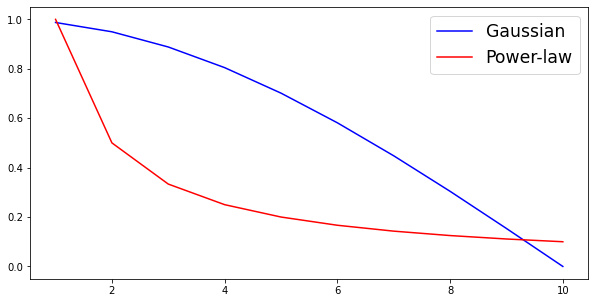

In [11]:
# Demonstrating the distance decays based on two different probability distributions

x = range(1, 11, 1)
y_gaus = []
y_power = []

for i in x:
    y_gaus.append(gaussian(i, 10))
    y_power.append(power(i, -1))

# Plot two distance decay functions
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y_gaus, label='Gaussian', color='blue')
ax.plot(x, y_power, label='Power-law', color='red')
plt.legend(fontsize='xx-large')

plt.show()

# 3. Calculating neighbors and weights with Gaussian probability distribution
Now, we would like to implement Gaussian distance decay for calculating spatial autocorrelation. It will be replacing step 2 described in the backbone of autocorrelation calculation. 

**3.1.** (1 point) Suppose we have 5000 meters as threshold bandwidth. Write lines of code in the below cell to calculate the list of neighbors of each community area. You want to structurize your result as a dictionary shown below. Namely, d_neighbors will be a dictionary that has the index of each community area as its key and the list of the neighboring community areas as its value.

```python
d_neighbors = {**index_of_area_1** : [**neighboring_area_1**, **neighboring_area_2**],
               **index_of_area_2** : [**neighboring_area_8**, **neighboring_area_9**, **neighboring_area_10**]
               ...
               **index_of_area_n** : [**neighboring_area_23**, **neighboring_area_1**, **neighboring_area_45**]
}
```

In [15]:
homicide.reset_index().explore()

In [13]:
# Your code here
d0 = 5000
d_neighbors = {}

for i in range(homicide.shape[0]):
    l_neighbors = []
    
    for j in range(homicide.shape[0]):
        if i != j:
            temp_dist = homicide.at[i, 'geometry'].centroid.distance(homicide.at[j, 'geometry'].centroid)
            
            if temp_dist <= d0:
                l_neighbors.append(j)
                
    d_neighbors[i] = l_neighbors
    
d_neighbors

{0: [1, 3, 75],
 1: [0, 3, 12, 13, 75],
 2: [3, 4, 5, 6, 75],
 3: [0, 1, 2, 4, 5, 12, 13, 15, 20, 75],
 4: [2, 3, 5, 6, 13, 15, 19, 20, 21, 75],
 5: [2, 3, 4, 6, 20, 21, 75],
 6: [2, 4, 5, 7, 21, 23],
 7: [6, 23, 27, 31, 32],
 8: [9, 10, 11],
 9: [8, 10, 11, 14, 16],
 10: [8, 9, 11, 12, 13, 14, 15, 16],
 11: [8, 9, 10, 12, 13, 14],
 12: [1, 3, 10, 11, 13, 14, 15, 75],
 13: [1, 3, 4, 10, 11, 12, 14, 15, 19, 20],
 14: [9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20],
 15: [3, 4, 10, 12, 13, 14, 18, 19, 20, 21],
 16: [9, 10, 14, 17, 18],
 17: [14, 16, 18, 24],
 18: [14, 15, 16, 17, 19, 20, 22, 24],
 19: [4, 13, 14, 15, 18, 20, 21, 22, 24],
 20: [3, 4, 5, 13, 14, 15, 18, 19, 21, 22],
 21: [4, 5, 6, 15, 19, 20, 22, 23, 26],
 22: [18, 19, 20, 21, 23, 24, 25, 26, 28],
 23: [6, 7, 21, 22, 26, 27, 31],
 24: [17, 18, 19, 22, 25],
 25: [22, 24, 26, 28, 29],
 26: [21, 22, 23, 25, 27, 28, 29, 30],
 27: [7, 23, 26, 28, 30, 31, 32, 33, 58, 59],
 28: [22, 25, 26, 27, 29, 30, 57],
 29: [25, 26, 28, 30, 56, 

In [14]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""
assert type(d_neighbors) == dict
assert d_neighbors[7] == [6, 23, 27, 31, 32]
assert d_neighbors[75] == [0, 1, 2, 3, 4, 5, 12]

print('Success!')

Success!


**3.2.** (1 point) Take advantage of the code you wrote in step 3.1, and make it as a function that also calculates the weights on each neighboring community area based on `gaussian()` function, not only the list of neighboring community areas. <br>
The structure of this function should be looked like the below. The reason for using this structure is that we want to enter this result into <a href=https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W>`libpysal.weights.W()`</a> to calculate Global and Local Moran's I, later. 
* Inputs:
    * `gdf`: (GeoDataFrame) the one we want to calculate neighbors and their weights (i.e., homicide)
    * `d0`: (int) threshold bandwidth (e.g., 5000)
* Outputs:
    * `d_neighbors`: (dict) {the_index_of_each_community_area: [the_list_of_neighboring_community_areas]} 
    * `d_weights`: (dict) {the_index_of_each_community_area: [the_list_of_neighboring_community_areas]} 

```python
def gaussian_weights(gdf, d0):
    d_neighbors = {}
    d_weights = {}
    
    # Your code ...
    
    # GOOD LUCK...
    
    return d_neighbors, d_weights
```

In [17]:
# your code here
def gaussian_weights(gdf, d0):
    d_neighbors = {}
    d_weights = {}
    
    for i in range(gdf.shape[0]):
        l_neighbors = []
        l_weights = []
        
        for j in range(gdf.shape[0]):
            if i != j:
                temp_dist = gdf.at[i, 'geometry'].centroid.distance(gdf.at[j, 'geometry'].centroid)
                
                if temp_dist <= d0:
            
                    l_neighbors.append(j)
                    l_weights.append(gaussian(temp_dist, d0))
                    
        d_neighbors[i] = l_neighbors
        d_weights[i] = l_weights
            
    return d_neighbors, d_weights

In [18]:
""" Test code for the previous code. This cell should NOT give any errors when it is run."""

assert type(gaussian_weights(homicide, 5000)[0]) == dict
assert type(gaussian_weights(homicide, 5000)[1]) == dict
assert gaussian_weights(homicide, 5000)[0][0] == [1, 3, 75]
assert gaussian_weights(homicide, 5000)[1][0] == [0.756463159645392, 0.27797791464592075, 0.6773174934481152]

print('Success!')

Success!


# 4. Calculate Spatial Autocorrelation with Gaussian probability distribution

Consult with the previous lecture, and find necessary codes for calculating Global Moran's I and Local Moran's I, respectively. Here, we want to use ***a fixed bandwidth approach*** and investigate the ***ideal*** threshold bandwidth that provides the maximum Z-score. 

The following are the backbones of the two methods. 
* **Global Moran's I**
    1. Extract coordinates from `homicide` GeoDataFrame with an array that has numerous tuples. 
    2. Calculate weights of each geographical units based on a Gaussian distance decay method with <a href=https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W>`libpysal.weights.W()`</a>. 
    3. Assign focused value with `homicide_count`. 
    4. Utilize `esda.moran.Moran()` function to obtain results. Moran's I, p-value, and Z-score will be embedded in `.I`, `.p_norm`, and `z_norm` attributes, respectively. 
    <br><br>
* **Local Moran's I (LISA: Local Indicators of Spatial Association)**
    1. Extract coordinates from `homicide` GeoDataFrame with an array that has numerous tuples. 
    2. Calculate weights of each geographical units based on a Gaussian distance decay method with <a href=https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W>`libpysal.weights.W()`</a>.  
    3. Assign focused value with `homicide_count`. 
    4. Utilize `esda.moran.Moran_Local()` function to obtain results. Classification of LISA and its significant level are embedded in `.q` and `p_sim` attributes.
    5. Find the significant classification results and merge it back to the original GeoDataFrame (i.e., homicide). 
    6. Plot LISA with the provided colors: {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}. 

**4.1.** (1 point) Change the fixed bandwidth from 1000 (meters) to 9000 with the increment of 1000, and find the most statistically significant result (i.e., the highest Z-score). **Manually write your answers of the ideal threshold distance, Moran's I, and Z-score at the end.** <br>

**Note**: In step 2, calculated `neighbors` and `weights` of community areas (from `homicide` GeoDataFrame) will be fed to <a href=https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W>`libpysal.weights.W()`</a> like shown below. 
```python
w = libpysal.weights.W(neighbors, weights, silence_warnings=True)
```
**Hint**: the highest Z-score is approximately 6.734.

In [17]:
# Your code here
for dist in range(1000, 10000, 1000):
    # Obtain coordinates of each geographical units
    coords = homicide.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

    # Calculate weights of each geographical units based on distance decay method. 
    neighbors, weights = gaussian_weights(homicide, dist)
    w = libpysal.weights.W(neighbors, weights, silence_warnings=True)
    
    # Focused variable
    y = homicide['homicide_count']

    # Calculate Moran's I
    mi = esda.moran.Moran(y, w)

    # Print results
    print(f"Moran's I with {dist} meter radius: {round(mi.I, 3)}, p-value: {round(mi.p_norm, 3)}, z-score: {round(mi.z_norm, 3)}")


/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/esda/moran.py:218: RuntimeWarning: invalid value encountered in double_scalars
  self.VI_norm = v_num / v_den - (1.0 / (n - 1)) ** 2
/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/esda/moran.py:230: RuntimeWarning: invalid value encountered in double_scalars
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/esda/moran.py:237: RuntimeWarning: divide by zero encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss


Moran's I with 1000 meter radius: nan, p-value: nan, z-score: nan
Moran's I with 2000 meter radius: 0.249, p-value: 0.294, z-score: 1.049
Moran's I with 3000 meter radius: 0.447, p-value: 0.0, z-score: 3.941
Moran's I with 4000 meter radius: 0.46, p-value: 0.0, z-score: 5.457
Moran's I with 5000 meter radius: 0.417, p-value: 0.0, z-score: 6.248
Moran's I with 6000 meter radius: 0.37, p-value: 0.0, z-score: 6.734
Moran's I with 7000 meter radius: 0.314, p-value: 0.0, z-score: 6.685
Moran's I with 8000 meter radius: 0.249, p-value: 0.0, z-score: 6.178
Moran's I with 9000 meter radius: 0.2, p-value: 0.0, z-score: 5.698


**4.2.** (1 point) Create a map of LISA with the most significant fixed bandwidth. Use the color scheme provided below. Here, we want to find the classification of LISA with **95% significance level**. Also, overlay the police stations `p_stations` on the LISA map. 
```python
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}
```
The result should look like the below. 

![](./data/fig2.jpg)

/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/zawoon96/opt/anaconda3/envs/geog489/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


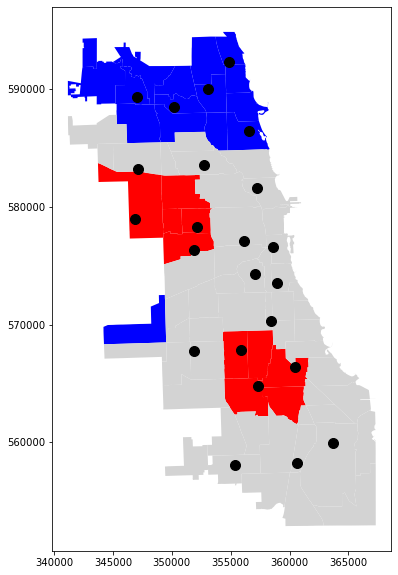

In [18]:
# Your code here

# Obtain coordinates of each geographical units
coords = homicide.apply(lambda x:x.geometry.centroid.coords[0], axis=1).values

# Calculate weights of each geographical units based on distance decay method. 
neighbors, weights = gaussian_weights(homicide, 6000)
w = libpysal.weights.W(neighbors, weights, silence_warnings=True)

# Focused variable
y = homicide['homicide_count']

# Calculate Local Moran's I
lm = esda.moran.Moran_Local(y, w)

# Assign the classification of LISA based on their significance level. 
lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
lisa = []
for idx in range(len(lm.q)):
    if lm.p_sim[idx] < 0.05:
        lisa.append(lm_dict[lm.q[idx]])
    else:
        lisa.append('Not_Sig')
        
lisa = pd.Series(lisa)
homicide['fixed'] = lisa

# Plotting 
lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'lightgrey'}

fig, ax = plt.subplots(figsize=(10, 10))
for key in lisa_color.keys():
    homicide.loc[homicide['fixed'] == key].plot(ax=ax, color=lisa_color[key], legend=True)
p_stations.plot(ax=ax, markersize=100, color='black')
    
plt.show()

### *You have finished Lab 5: Spatial Autocorrelation*

Please name your jupyter notebook as `GEOG489_Lab5_[YOUR_NET_ID].ipynb`, and upload it to https://learn.illinois.edu. 